<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.9.5.7-LSTMB128_dr20_rdr20_batch128_lr01-GloVe_with_stop_nonlemmatized-4m-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained GloVe embedding using LSTM with 4m samples without removing stop words

For this notebookw, we will train with the following LSTM architectuure

* Glove embedding with 300 dimension vectors
* max sequence length of 100 words (this is same as what we've been doing)
* 128 LSTM cells 
* dropout rate: 0.2
* recurrent dropout rate: 0.2
* learning rate of 0.01
* batch size of 128
* 20 epochs




In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.2.0


import tensorflow as tf

print(f'Tensorflow version: {tf.__version__}')
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Tensorflow version: 2.2.0


'/device:GPU:0'

In [3]:
# check what GPU we got
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# check that we are using high RAM runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Thu May 28 14:39:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from datetime import datetime


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False


# length of our embedding - 300 is standard
EMBED_SIZE = 300
# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

LSTM_DIM = 128 # total LSTM units
EPOCHS  = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.2
RECURRENT_DROPOUT_RATE = 0.2
PATIENCE = 4
BIDIRECTIONAL = False
BALANCE_CLASS_WEIGHTS = True
TRAIN_EMBEDDINGS = False
FEATURE_SET_NAME = "glove_with_stop_nonlemmatized"
SAMPLES = "4m"
MODEL_VERSION = 1
PLATEAU_PATIENCE = 2
ENVIRONMENT = "6.9.5.7-LSTMB128_dr20_rdr20_batch128_lr01-GloVe_with_stop_nonlemmatized-4m-prototype.ipynb"





if BIDIRECTIONAL:
  bidirectional_name = "bi"
else:
  bidirectional_name = ""

if BALANCE_CLASS_WEIGHTS:
  balanced_name = "B"
else:
  balanced_name = ""

MODEL_NAME = f"{bidirectional_name}LSTM{balanced_name}{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, Dropout {DROPOUT_RATE}, Recurrent Dropout {RECURRENT_DROPOUT_RATE}, Batch Size {BATCH_SIZE}, Learning Rate {LEARNING_RATE}"

REPORT_FILE = f"{MODEL_NAME}_" \
              f"dr{ku.get_decimal_str(DROPOUT_RATE)}_" \
              f"rdr{ku.get_decimal_str(RECURRENT_DROPOUT_RATE)}_" \
              f"batch{BATCH_SIZE}_" \
              f"lr{ku.get_decimal_str(LEARNING_RATE)}-{FEATURE_SET_NAME}-dl_prototype-report.csv"


if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename(f"test-{REPORT_FILE}")

else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename(REPORT_FILE)


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'




start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]

# Preprocessing

In [6]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=282132
Number of Documents=3366993
Train review vectors shape: (3366993, 100)  Test review vectors shape: (1122331, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [7]:

EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'

embeddings_index = {}

if os.path.exists(f'{EMBEDDING_INDEX_FILE}.npy'):
  print(f'Loading {EMBEDDING_INDEX_FILE}.npy')
  embeddings_index = np.load(f'{EMBEDDING_INDEX_FILE}.npy', 
                             allow_pickle = True).item()
else:
  print('Indexing word vectors.')

  with open(EMBEDDING_FILE) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  np.save(EMBEDDING_INDEX_FILE, embeddings_index)

print(type(embeddings_index))
print(np.shape(embeddings_index))
print('Found %s word vectors.' % len(embeddings_index))




Loading drive/My Drive/Springboard/capstone/models/glove.840B.300d-embedding_index.npy
<class 'dict'>
()
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [8]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 282133
embedding_matrix shape: (282134, 300)
Number of missing words from our vocabulary: 164935


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words).sort_values(0)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [10]:
vocab_size = len(t.word_index)+1

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True,
                              # patience = PLATEAU_PATIENCE,
                              factor = 0.5,
                              verbose = 1)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

mw = ku.LSTM1LayerModelWrapper(
                        lstm_dim = LSTM_DIM, # LSTM dim - LSTM1LyerModelWrapper
                          dropout_rate = DROPOUT_RATE, # dropout rate - LSTM1LyerModelWrapper
                          recurrent_dropout_rate = RECURRENT_DROPOUT_RATE, # recurrent dropout rate - LSTM1LyerModelWrapper
                          bidirectional = BIDIRECTIONAL, # bidirectional - LSTM1LyerModelWrapper
                          vocab_size = vocab_size,       # vocab size - EmbeddingModelWrapper
                          max_sequence_length = MAX_SEQUENCE_LENGTH, # max sequence length - EmbeddingModelWrapper
                          embed_size = EMBED_SIZE, # embed size - EmbeddingModelWrapper
                        train_embeddings  =  TRAIN_EMBEDDINGS, # trainable embedding - EmbeddingModelWrapper
                        embedding_matrix = embedding_matrix,
                        model_name = MODEL_NAME, # model name - ModelWrapper
                        architecture = ARCHITECTURE, # architecture - ModelWrapper
                        feature_set_name = FEATURE_SET_NAME, # feature_set_name - ModelWrapper
                        label_column = LABEL_COLUMN, # label_column - ModelWrapper
                        feature_column = FEATURE_COLUMN, # feature_column - ModelWrapper
                        data_file = DATA_FILE, # data file - ModelWrapper
                        sample_size_str = SAMPLES, # sample size
                        tokenizer = t, # tokenizer - ModelWrapper
                        description = DESCRIPTION, #description - ModelWrapper
                        optimizer_name = "Adam", # string optimizer name
                        learning_rate = LEARNING_RATE, # learning rate - ModelWrapper
                        # TODO: this should be in fit instead but need it to define name for the
                        # checkpoint location - move later
                        batch_size = BATCH_SIZE, # batch size - ModelWrapper
                        model_version= MODEL_VERSION, # model version - ModelWrapper
                        save_dir = DRIVE_DIR # where to save outputs - ModelWrapper
)

mw.add("environment", ENVIRONMENT)
mw.add("patience", PATIENCE)
mw.add("plateau_patience", PLATEAU_PATIENCE)

network_history = mw.fit(X_train, y_train,
                      epochs = EPOCHS,
                      verbose = 1,
                      validation_split = 0.2,
                      balance_class_weights = BALANCE_CLASS_WEIGHTS,
                      callbacks=[early_stop, reduce_lr])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          84640200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 84,860,493
Trainable params: 220,293
Non-trainable params: 84,640,200
_________________________________________________________________
Build model:
None
Starting training on model:

ModelWrapper parameters:
	tf_version:			2.2.0
	model_name:			LSTMB128
	description:			1 Layer 128 LSTM Units, Dropout 0.2, Recurrent Dropout 0.2, Batch Size 128, Learning Rate 0.01
	architecture:			1x128
	feature_set_name:		glove_with_stop_nonlemmatized
	label_column:			star_rating
	feature_column:			review_body
	data_f

In [11]:
scores = mw.evaluate(X_test, y_test)
print("Training Accuracy: %.2f%%" % (mw.train_scores[1]*100))
print(f'Training Score: {ru.calculate_metric(mw.train_crd)}')
print("Test Accuracy: %.2f%%" % (mw.test_scores[1]*100))
print(f'Test Score: {ru.calculate_metric(mw.test_crd)}')

mw.save(append_report=True)


Number of test: 1122331
Running model.evaluate on test set...
35073/35073 [==============================] - 1148s 33ms/step - loss: 0.8621 - categorical_accuracy: 0.6524
Running model.predict on test set...
Unencode test set predictions...
Generating test set confusion matrix...
Calculating test set ROC AUC...
(1122331, 5)
Getting test set classification report...
Running model.evaluate on training set...
105219/105219 [==============================] - 3440s 33ms/step - loss: 0.8626 - categorical_accuracy: 0.6525
Running model.predict on training set...
Unencode training set predictions...
Generating training set confusion matrix...
Calculating training set ROC AUC...
(3366993, 5)
Getting training set classification report...
Training Accuracy: 65.25%
Training Score: 0.4885538211416248
Test Accuracy: 65.24%
Test Score: 0.48661214875436415
Saving to report file: drive/My Drive/Springboard/capstone/reports/LSTMB128_dr2_rdr2_batch128_lr01-glove_with_stop_nonlemmatized-dl_prototype-repor

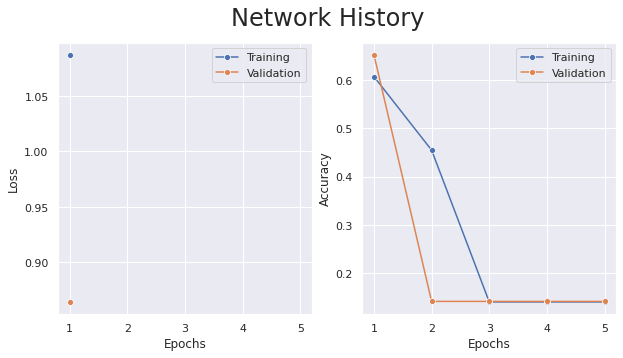


Confusion Matrix
[[117105  26362   9318   2131   2842]
 [ 26785  25212  16584   3756   2066]
 [ 11387  20570  40164  21624   7831]
 [  3931   7689  28174  82172  65440]
 [  9031   7711  19743  97105 467598]]

Classification Report
              precision    recall  f1-score   support

           1       0.70      0.74      0.72    157758
           2       0.29      0.34      0.31     74403
           3       0.35      0.40      0.37    101576
           4       0.40      0.44      0.42    187406
           5       0.86      0.78      0.82    601188

    accuracy                           0.65   1122331
   macro avg       0.52      0.54      0.53   1122331
weighted avg       0.67      0.65      0.66   1122331



drive/My Drive/Springboard/capstone/util/plot_util.py:283: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:283: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:287: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:287: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

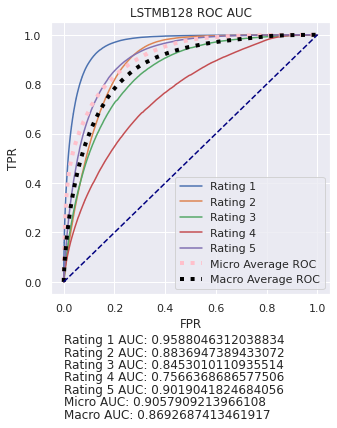

In [12]:


pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.test_confusion_matrix)

print("\nClassification Report")
print(mw.test_classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.test_roc_auc, mw.test_fpr, mw.test_tpr)



# Test That Our Models Saved Correctly

In [0]:
# from tensorflow.keras.models import load_model

# model_loaded = load_model(mw.model_file)
# scores = model_loaded.evaluate(X_test, y_test, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# # this takes too long for real models
# if DEBUG == True:
#   y_predict = model_loaded.predict(X_test)
#   y_predict_unencoded = ku.unencode(y_predict)
#   y_test_unencoded = ku.unencode(y_test)

#   # classification report
#   print(classification_report(y_test_unencoded, y_predict_unencoded))

#   # confusion matrix
#   print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


In [14]:
end_time = datetime.now()
print(f'Model:\n{mw}')
print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Total Duraction {round((end_time - start_time).total_seconds() / 60, 2)} mins")

Model:

ModelWrapper parameters:
	tf_version:			2.2.0
	model_name:			LSTMB128
	description:			1 Layer 128 LSTM Units, Dropout 0.2, Recurrent Dropout 0.2, Batch Size 128, Learning Rate 0.01
	architecture:			1x128
	feature_set_name:		glove_with_stop_nonlemmatized
	label_column:			star_rating
	feature_column:			review_body
	data_file:			drive/My Drive/Springboard/capstone/data/amazon_reviews_us_Wireless_v1_00-4m-with_stop_nonlemmatized-preprocessed.csv
	batch_size:			128
	sample_size:			4m
	sampling_type:			none
	tokenizer:			<keras_preprocessing.text.Tokenizer object at 0x7f7eb6ee6e48>
	save_weights:			True
	optimizer:			Adam
	learning_rate:			0.01
	version:			1
	save_dir:			drive/My Drive/Springboard/capstone
	load_model_file:			None

	Report Output:
		report_file:			drive/My Drive/Springboard/capstone/reports/LSTMB128_dr2_rdr2_batch128_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv

	Model Output:
		tokenizer_file:			drive/My Drive/Springboard/capstone/models/LSTMB128-1x128